#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행 
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

* 함수 생성

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [17]:
import joblib
data_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/data01_train.csv'
fi_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/feature_importances.pkl'
data = pd.read_csv(data_path)
fi = joblib.load(fi_path)

In [18]:
data.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [19]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [20]:
data.shape

(5881, 562)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [22]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [23]:
data.isnull().sum()

tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Activity                                0
Length: 562, dtype: int64

In [24]:
data.isnull().sum().sum()

0

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다. 


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [25]:
x = data.drop('Activity', axis=1)
y = data.loc[:, 'Activity']

### (2) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

### (3) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

<Axes: >

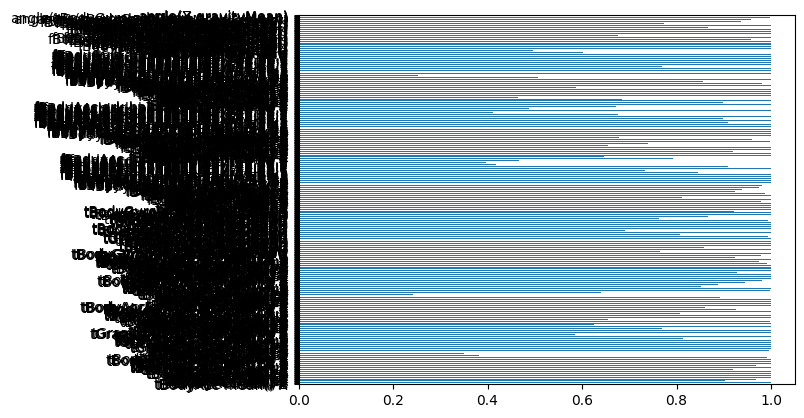

In [27]:
x_train.max().plot(kind='barh')

<Axes: >

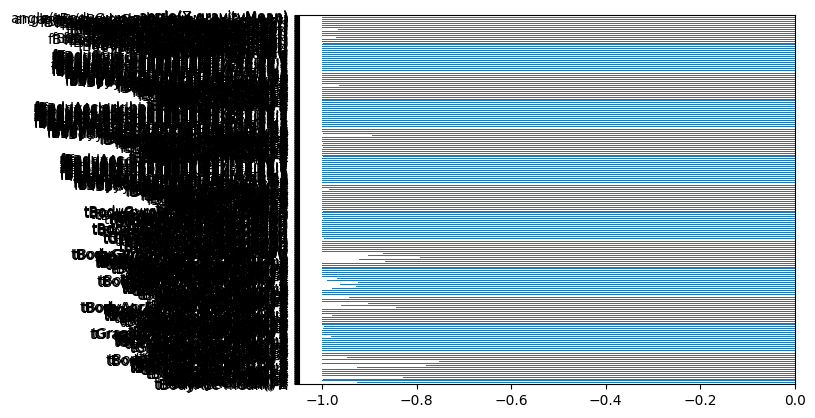

In [28]:
x_train.min().plot(kind='barh')

In [29]:
mm_scaler = MinMaxScaler()
x_train_scaled = mm_scaler.fit_transform(x_train)
x_val_scaled = mm_scaler.transform(x_val)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다. 
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

### (1) 알고리즘1 : 

In [30]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

rf.score(x_val, y_val)

0.9796091758708582

In [46]:
for i in range(10, 101, 10):
    cols = fi.sort_values(by='feature_importance_sum')['feature_name'].values[:i]
    temp_x = x_train[cols]
    rf = RandomForestClassifier()
    rf.fit(temp_x, y_train)
    print(f"{i} : {rf.score(x_val[cols], y_val)}")

10 : 0.5471537807986406
20 : 0.5853865760407817
30 : 0.6117247238742566
40 : 0.6355140186915887
50 : 0.6618521665250637
60 : 0.6737468139337298
70 : 0.6805437553101105
80 : 0.7043330501274426
90 : 0.7170773152081563
100 : 0.7179269328802039


In [49]:
for i in range(100, 551, 50):
    cols = fi.sort_values(by='feature_importance_sum')['feature_name'].values[:i]
    temp_x = x_train[cols]
    rf = RandomForestClassifier()
    rf.fit(temp_x, y_train)
    print(f"{i} : {rf.score(x_val[cols], y_val)}")

100 : 0.7221750212404418
150 : 0.7952421410365336
200 : 0.836873406966865
250 : 0.8538657604078165
300 : 0.8802039082412915
350 : 0.9150382327952421
400 : 0.9311809685641461
450 : 0.929481733220051
500 : 0.929481733220051
550 : 0.9430756159728122


### (2) 알고리즘2 : 

In [52]:
from sklearn.svm import SVC

model = SVC()
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print('Accuracy :', accuracy_score(y_val, y_pred))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       223
           SITTING       0.94      0.91      0.92       206
          STANDING       0.92      0.94      0.93       218
           WALKING       0.99      1.00      1.00       200
WALKING_DOWNSTAIRS       0.98      0.99      0.99       158
  WALKING_UPSTAIRS       0.99      0.97      0.98       172

          accuracy                           0.97      1177
         macro avg       0.97      0.97      0.97      1177
      weighted avg       0.97      0.97      0.97      1177

[[223   0   0   0   0   0]
 [  1 187  17   0   0   1]
 [  0  13 205   0   0   0]
 [  0   0   0 200   0   0]
 [  0   0   0   0 157   1]
 [  0   0   0   2   3 167]]
Accuracy : 0.967714528462192


In [55]:
for i in range(100, 551, 50):
    cols = fi.sort_values(by='feature_importance_sum')['feature_name'].values[:i]
    temp_x = x_train[cols]
    model = SVC()
    model.fit(temp_x, y_train)
    print(f"{i} : {model.score(x_val[cols], y_val)}")

100 : 0.7128292268479184
150 : 0.7629566694987255
200 : 0.806287170773152
250 : 0.8360237892948174
300 : 0.8606627017841971
350 : 0.8802039082412915
400 : 0.8895497026338148
450 : 0.9014443500424809
500 : 0.913338997451147
550 : 0.9286321155480034


### (3) 알고리즘3 : 

In [56]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=42)
model.fit(x_train.values, y_train.values)

model.score(x_val, y_val)

0.9881053525913339

In [61]:
for i in range(100, 551, 50):
    cols = fi.sort_values(by='feature_importance_sum')['feature_name'].values[:i]
    temp_x = x_train[cols]
    model = LGBMClassifier(random_state=42)
    model.fit(temp_x.values, y_train.values)
    print(f"{i} : {model.score(x_val[cols].values, y_val.values)}")

100 : 0.7986406117247239
150 : 0.8589634664401019
200 : 0.9014443500424809
250 : 0.913338997451147
300 : 0.9337298215802888
350 : 0.9422259983007647
400 : 0.9583687340696686
450 : 0.9617672047578589
500 : 0.9600679694137638
550 : 0.9745114698385726


### (4) 알고리즘4 : 

In [62]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_val_le = le.transform(y_val)

model = XGBClassifier(random_state=42)
model.fit(x_train.values, y_train_le)

model.score(x_val, y_val_le)

0.9889549702633815

In [67]:
for i in range(100, 501, 100):
    cols = fi.sort_values(by='feature_importance_sum')['feature_name'].values[:i]
    temp_x = x_train[cols]
    model = XGBClassifier(random_state=42)
    model.fit(temp_x.values, y_train_le)
    print(f"{i} : {model.score(x_val[cols].values, y_val_le)}")

100 : 0.7986406117247239
200 : 0.8980458793542906
300 : 0.9167374681393373
400 : 0.9532710280373832
500 : 0.9498725573491928


### (5) AUTO ML

#### Caret AutoML

In [68]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requ

In [69]:
import pycaret
pycaret.__version__

'3.0.0'

In [70]:
from pycaret.classification import ClassificationExperiment
s = ClassificationExperiment()
s.setup(data, target = 'Activity', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Activity
2,Target type,Multiclass
3,Target mapping,"LAYING: 0, SITTING: 1, STANDING: 2, WALKING: 3, WALKING_DOWNSTAIRS: 4, WALKING_UPSTAIRS: 5"
4,Original data shape,"(5881, 562)"
5,Transformed data shape,"(5881, 562)"
6,Transformed train set shape,"(4116, 562)"
7,Transformed test set shape,"(1765, 562)"
8,Numeric features,561
9,Preprocess,True


In [71]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9891,0.9998,0.9891,0.9892,0.9891,0.9868,0.9869,37.7450
xgboost,Extreme Gradient Boosting,0.9859,0.9998,0.9859,0.9861,0.9859,0.9830,0.9831,72.6730
lr,Logistic Regression,0.9849,0.9993,0.9849,0.9851,0.9849,0.9819,0.9819,12.2290
gbc,Gradient Boosting Classifier,0.9837,0.9995,0.9837,0.9839,0.9837,0.9804,0.9805,363.3520
et,Extra Trees Classifier,0.9820,0.9994,0.9820,0.9824,0.9820,0.9784,0.9784,1.8710
ridge,Ridge Classifier,0.9798,0.0000,0.9798,0.9801,0.9798,0.9757,0.9758,0.3460
lda,Linear Discriminant Analysis,0.9794,0.9990,0.9794,0.9795,0.9793,0.9751,0.9752,1.3880
rf,Random Forest Classifier,0.9728,0.9992,0.9728,0.9731,0.9728,0.9673,0.9673,6.1650
svm,SVM - Linear Kernel,0.9706,0.0000,0.9706,0.9726,0.9705,0.9646,0.9651,1.0260
knn,K Neighbors Classifier,0.9531,0.9948,0.9531,0.9541,0.9529,0.9436,0.9439,0.5480


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [72]:
print(best)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

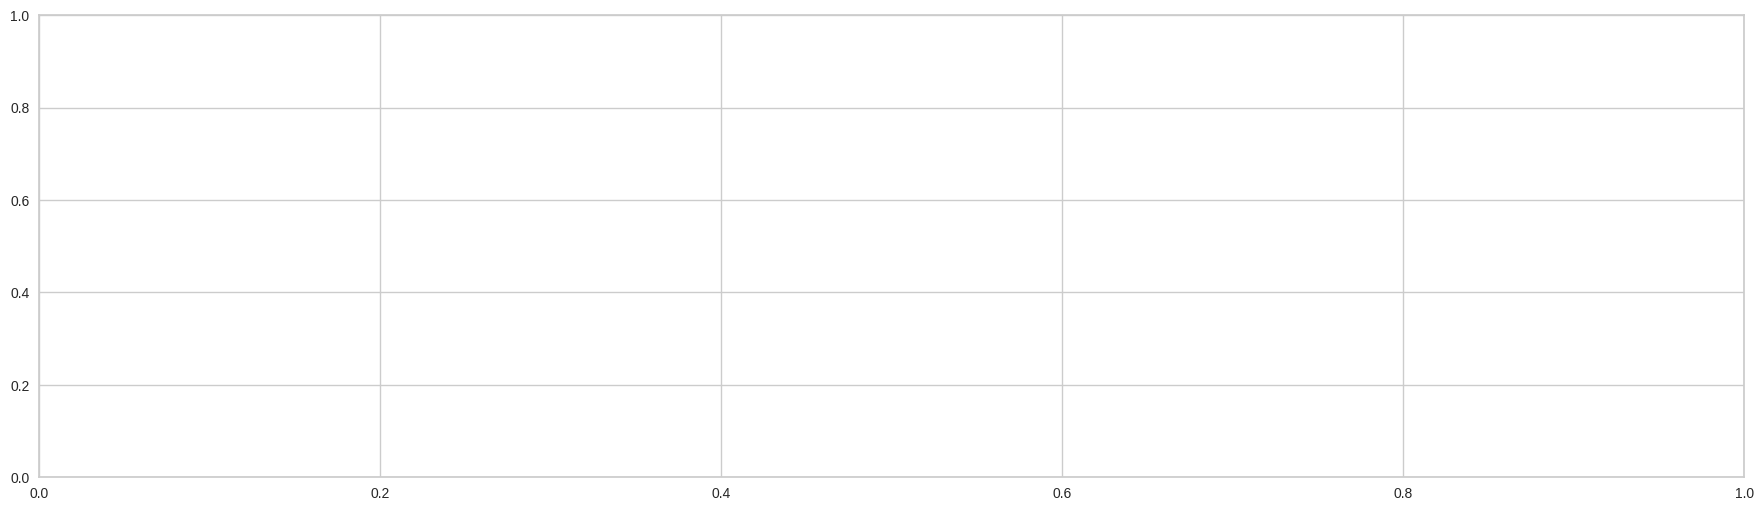

In [73]:
s.evaluate_model(best)

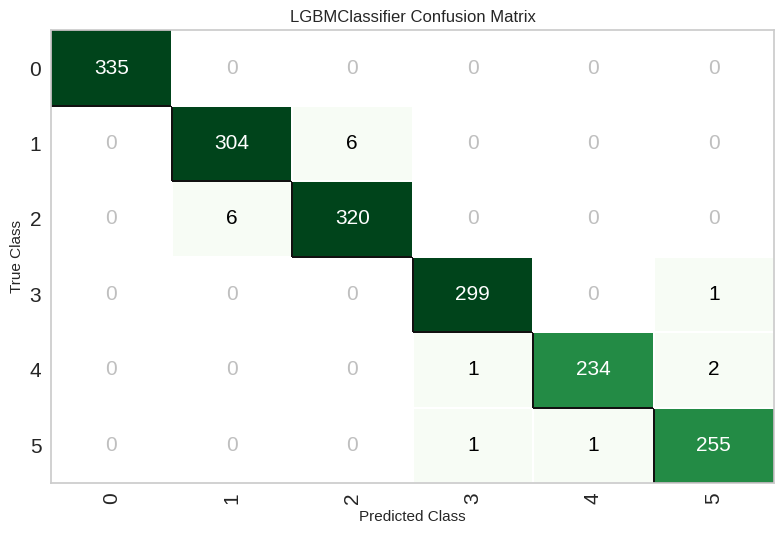

In [74]:
s.plot_model(best, plot='confusion_matrix')

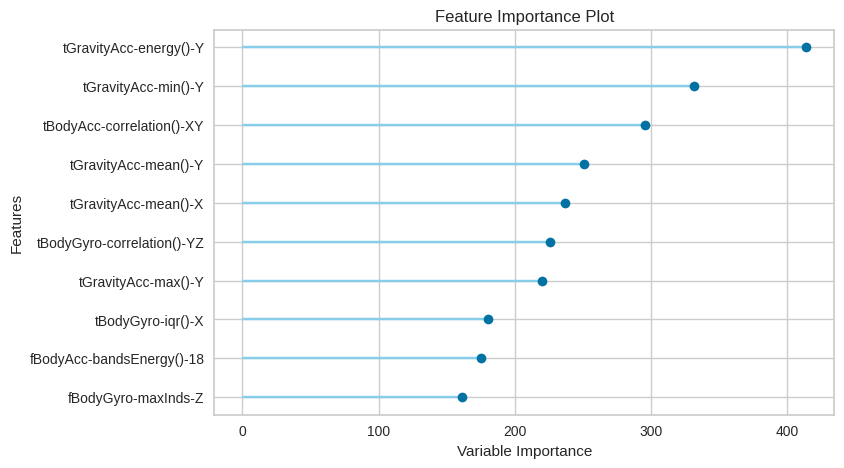

In [75]:
s.plot_model(best, plot='feature')

#### mljar AutoML

In [76]:
!pip install mljar-supervised

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00
  Created wheel for mljar-supervised: filename=mljar_supervised-0.11.5-py3-none-any.whl size=147060 sha256=9152456a65fbc53d4cbfd69691274e6a9e6fd926ef09daf81c158ddb7b99f7e1
  Stored in directory: /root/.cache/pip/wheels/62/ed/f2/9a70a649613cf977a8b1e39ce373d14290a135fa309c1f1638
Successfully b

In [77]:
from supervised.automl import AutoML

In [78]:
%%time
automl = AutoML(mode='Compete')
automl.fit(x_train, y_train)

predictions = automl.predict_all(x_val)
print(predictions.head())
print("Validation accuracy :", accuracy_score(y_val, predictions['label'].astype(int)))

Disable stacking for split validation
AutoML directory: AutoML_1
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['Decision Tree', 'Linear', 'Random Forest', 'Extra Trees', 'LightGBM', 'Neural Network', 'Nearest Neighbors']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
* Step simple_algorithms will try to check up to 4 models
1_DecisionTree logloss 0.510156 trained in 3.95 seconds
2_DecisionTree logloss 0.344143 trained in 3.66 seconds
3_DecisionTree logloss 0.344143 trained in 3.15 seconds
4_Linear logloss 0.046123 trained in 12.26 seconds
* Step default_algorithms will try to check up to 4 models
5_Default_LightGBM logloss 0.031333 trained in 134.62 seconds
6_Default_NeuralNetwork logloss 0.297313 trained in 11.32 seconds
7_Default_RandomForest logloss 0.2

ValueError: ignored

In [79]:
print(predictions.head())

   prediction_LAYING  prediction_SITTING  prediction_STANDING  \
0       9.999995e-01        4.621806e-07         5.018364e-08   
1       6.483160e-08        9.999993e-01         5.847454e-07   
2       1.169152e-08        1.965161e-08         4.577072e-08   
3       9.999977e-01        2.263253e-06         5.423634e-08   
4       1.324611e-07        9.999855e-01         1.387896e-05   

   prediction_WALKING  prediction_WALKING_DOWNSTAIRS  \
0        6.706518e-09                   5.143907e-09   
1        2.557654e-08                   2.014800e-08   
2        9.999999e-01                   1.642333e-08   
3        5.410995e-09                   3.165568e-09   
4        3.356162e-07                   8.038333e-08   

   prediction_WALKING_UPSTAIRS    label  
0                 7.537098e-09   LAYING  
1                 2.374293e-08  SITTING  
2                 2.851695e-08  WALKING  
3                 3.741750e-09   LAYING  
4                 9.242274e-08  SITTING  


In [80]:
print("Validation accuracy :", accuracy_score(y_val, predictions['label']))

Validation accuracy : 0.9906542056074766
